for classification rerun this part only

In [ ]:
import torch

In [ ]:
import os
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from google.colab import drive

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
num_classes = 80
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 103MB/s]


In [ ]:
checkpoint_path = '/content/drive/MyDrive/Model_Checkpoints/checkpoint_epoch_9.pt'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

<ipython-input-9-ff79f929b36c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
class CustomImageFolder(ImageFolder):
    def find_classes(self, directory):
        # Override find_classes to ignore hidden folders like .ipynb_checkpoints
        classes = [d.name for d in os.scandir(directory) if d.is_dir() and not d.name.startswith('.')]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform)
        # Filter out any files that do not end with valid image extensions
        self.samples = [(path, class_idx) for path, class_idx in self.samples
                        if path.lower().endswith(('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp'))]

In [ ]:
data_dir = '/content/drive/MyDrive/Medicinal_Leaf_dataset'  # Update to your dataset path

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset = CustomImageFolder(root=data_dir, transform=transform)

In [ ]:
classes = dataset.classes  # Retrieves class names from the dataset

In [ ]:
def load_and_predict(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    predicted_class = classes[predicted.item()]
    return predicted_class


In [ ]:
# Predict for a given image
image_path = '/content/WhatsApp Image 2024-11-06 at 15.40.43_752da98d.jpg'
predicted_class = load_and_predict(image_path)
print(f"The predicted class is: {predicted_class}")

The predicted class is: Mango


### **extra **

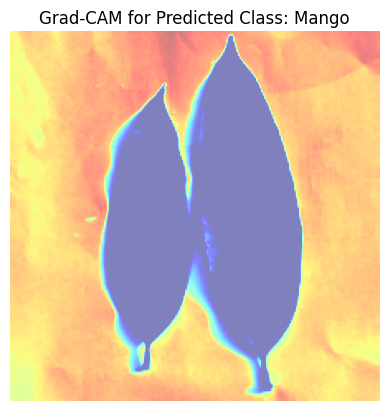

Predicted Class: Mango


In [ ]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    return image

def generate_gradcam(image, model):
    # Forward pass with gradient tracking
    image.requires_grad = True
    output = model(image)

    # Extract the predicted class and score
    predicted_class_idx = output.argmax().item()
    score = output[0][predicted_class_idx]

    # Backward pass to get gradients
    model.zero_grad()
    score.backward(retain_graph=True)

    # Grad-CAM calculation
    gradients = image.grad[0].cpu().numpy()
    weights = np.mean(gradients, axis=(1, 2))
    gradcam = np.sum(weights[:, None, None] * image[0].cpu().detach().numpy(), axis=0)

    gradcam = np.maximum(gradcam, 0)
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())

    # Plot Grad-CAM heatmap overlay
    plt.imshow(gradcam, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM for Predicted Class: {classes[predicted_class_idx]}")
    plt.axis('off')
    plt.show()

    #predicted class label
    predicted_class_label = classes[predicted_class_idx]
    return predicted_class_label

# Loading and preprocessing
image_path = '/content/WhatsApp Image 2024-11-06 at 15.40.43_752da98d.jpg'
image_tensor = preprocess_image(image_path)

predicted_class = generate_gradcam(image_tensor, model)
print(f"Predicted Class: {predicted_class}")

